<a href="https://colab.research.google.com/github/Anju982/data-science-portfolio/blob/main/Anti_Money_Laundering_Transaction_Data_(SAML_D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔍 End-to-End Anti-Money Laundering (AML) Detection
A Machine Learning Case Study using XGBoost and SMOTE
Author: Anjana Urulugastenna Date: 2026-02-07

1. Executive Summary
Money laundering involves disguising financial assets so they can be used without detection of the illegal activity that produced them. In this project, we develop a robust machine learning pipeline to detect illicit transactions in a high-volume, highly imbalanced dataset.

Key Technical Features:

Feature Engineering: Created temporal behavioral features (velocity, volume) to capture transaction patterns.

Imbalance Handling: Implemented SMOTE (Synthetic Minority Over-sampling Technique) to address the ~0.1% fraud rate.

Model Architecture: XGBoost Classifier within a scikit-learn / imblearn Pipeline.

Evaluation: Focused on Precision-Recall (AUPRC) rather than Accuracy to minimize false negatives.

In [1]:
# --- Imports ---
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve, auc)

# Advanced Algorithms & Imbalanced Learning
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Critical for using SMOTE in a pipeline

# --- Configuration ---
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
RANDOM_STATE = 42

print("✅ Environment Setup Complete.")

✅ Environment Setup Complete.


Data Ingestion

In [2]:
def load_data(sample_size=200000):
    """
    Downloads and loads the AML dataset. Samples the data if it exceeds the limit.
    """
    print("⏳ Downloading/Loading dataset...")
    path = kagglehub.dataset_download("berkanoztas/synthetic-transaction-monitoring-dataset-aml")
    csv_path = os.path.join(path, "SAML-D.csv")

    if not os.path.exists(csv_path):
        raise FileNotFoundError("Dataset not found. Check KaggleHub download path.")

    df = pd.read_csv(csv_path)
    print(f"Original Dataset Shape: {df.shape}")

    # Sampling strategy: ensure we don't drop all fraud cases if we sample
    if len(df) > sample_size:
        # Stratified sampling could be better, but simple random sampling is used here for speed
        df = df.sample(n=sample_size, random_state=RANDOM_STATE)

    print(f"Working Sample Shape: {df.shape}")
    return df

# Load the data
raw_df = load_data()

⏳ Downloading/Loading dataset...
Using Colab cache for faster access to the 'synthetic-transaction-monitoring-dataset-aml' dataset.
Original Dataset Shape: (9504852, 12)
Working Sample Shape: (200000, 12)


Feature Engineerin

In [3]:
def engineer_features(df):
    """
    Generates temporal features (rolling windows) and cleans the dataset.
    """
    print("⚙️ Engineering features...")
    df = df.copy()

    # 1. Datetime Conversion
    df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # 2. Sort for Rolling Window Calculation
    df = df.sort_values(['Sender_account', 'Timestamp']).reset_index(drop=True)

    # 3. Define Rolling Logic
    def calculate_rolling(group):
        group = group.sort_values('Timestamp')
        # rolling('24h') requires a datetime index or 'on' parameter
        group['TX_Count_24h'] = group.rolling('24h', on='Timestamp')['Amount'].count()
        group['Total_Vol_24h'] = group.rolling('24h', on='Timestamp')['Amount'].sum()
        return group[['TX_Count_24h', 'Total_Vol_24h']]

    # 4. Apply GroupBy (Optimized)
    # Note: complex rolling groupbys can be slow; this is a standard approach
    rolling_features = df.groupby('Sender_account', group_keys=False).apply(calculate_rolling)

    # 5. Merge features back
    df = df.merge(rolling_features, left_index=True, right_index=True, how='left')

    # 6. Column Selection & Cleaning
    # Removing high-cardinality IDs and location strings to prevent overfitting
    keep_cols = [
        'Amount', 'Payment_currency', 'Received_currency',
        'Payment_type', 'TX_Count_24h', 'Total_Vol_24h', 'Is_laundering'
    ]

    df_clean = df[keep_cols].copy()

    # Log transform 'Amount' as financial data is often right-skewed
    # (Optional but recommended for some models; Tree-based models handle this well regardless)
    # df_clean['Amount_Log'] = np.log1p(df_clean['Amount'])

    return df_clean

# Process the data
df_processed = engineer_features(raw_df)

# Check Class Distribution
counts = df_processed['Is_laundering'].value_counts()
print(f"\nClass Distribution:\n{counts}")
print(f"Fraud Rate: {counts.get(1, 0) / len(df_processed):.4%}")

df_processed.head()

⚙️ Engineering features...

Class Distribution:
Is_laundering
0    199816
1       184
Name: count, dtype: int64
Fraud Rate: 0.0920%


/tmp/ipython-input-2053962091.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_features = df.groupby('Sender_account', group_keys=False).apply(calculate_rolling)


,Amount,Payment_currency,Received_currency,Payment_type,TX_Count_24h,Total_Vol_24h,Is_laundering
0,7739.89,UK pounds,UK pounds,Cheque,1.0,7739.89,0
1,3997.72,UK pounds,UK pounds,ACH,1.0,3997.72,0
2,8530.75,UK pounds,UK pounds,Cheque,1.0,8530.75,0
3,1292.83,UK pounds,UK pounds,Cheque,1.0,1292.83,0
4,10947.45,UK pounds,UK pounds,ACH,1.0,10947.45,0


Exploratory Data Analysis (EDA)

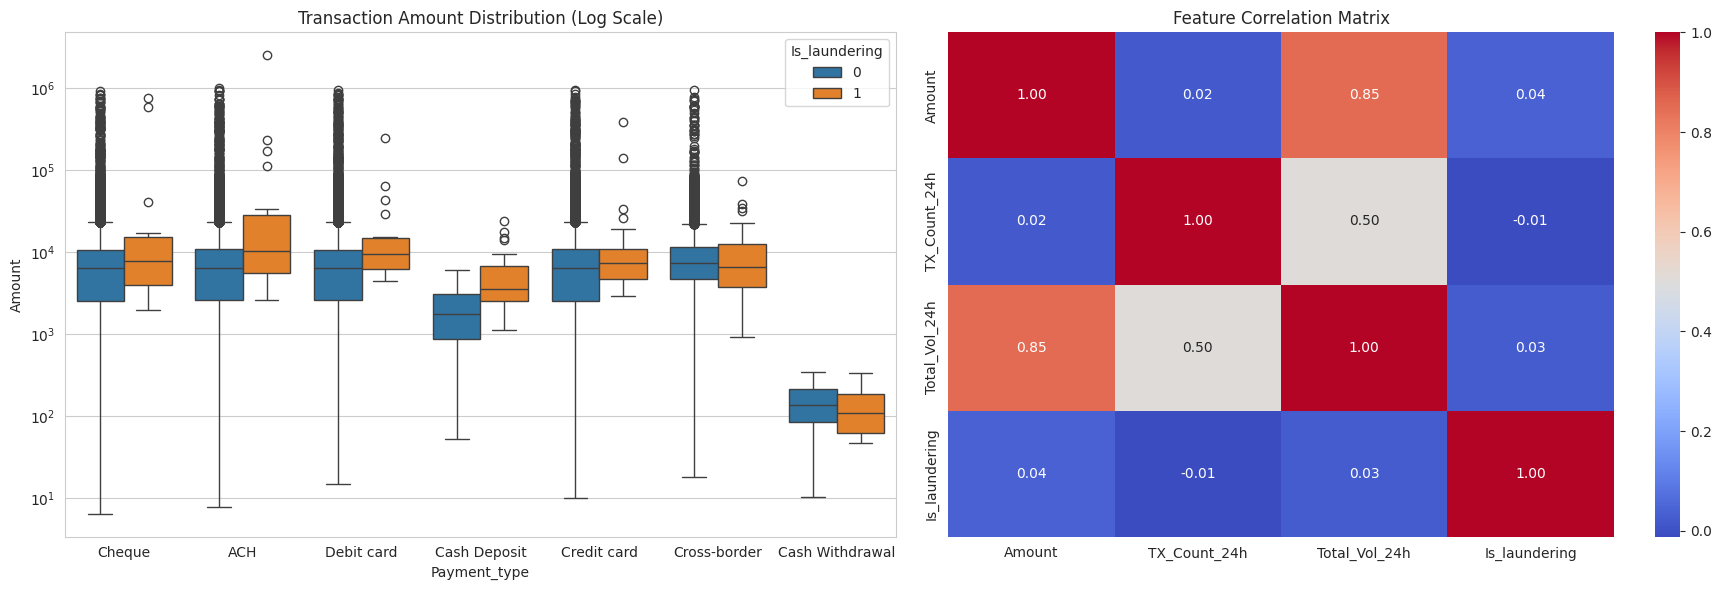

In [4]:
def plot_eda(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Transaction Amounts by Type and Class
    sns.boxplot(ax=axes[0], x='Payment_type', y='Amount', hue='Is_laundering', data=df)
    axes[0].set_yscale('log')
    axes[0].set_title("Transaction Amount Distribution (Log Scale)")

    # Plot 2: Correlation Heatmap (Numeric only)
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(ax=axes[1], data=corr, annot=True, cmap='coolwarm', fmt=".2f")
    axes[1].set_title("Feature Correlation Matrix")

    plt.tight_layout()
    plt.show()

plot_eda(df_processed)

Model Training (Pipeline with SMOTE)

Model Architecture
We use an XGBoost Classifier integrated into an imblearn Pipeline.

Preprocessing: OneHotEncoder for categorical variables (Currencies, Payment Type) and StandardScaler for numerical ones.

Resampling: SMOTE is applied only during training to oversample the minority class (money laundering) and fix the imbalance.

Classifier: XGBoost is trained on the balanced batch.

In [5]:
# 1. Split Data
X = df_processed.drop('Is_laundering', axis=1)
y = df_processed['Is_laundering']

# Stratified Split to maintain fraud ratio in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 2. Define Preprocessor
categorical_cols = ['Payment_currency', 'Received_currency', 'Payment_type']
numerical_cols = ['Amount', 'TX_Count_24h', 'Total_Vol_24h']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# 3. Build Pipeline
# Note: We use ImbPipeline (from imblearn) instead of sklearn Pipeline to support SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', XGBClassifier(
        n_estimators=100,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=RANDOM_STATE
    ))
])

# 4. Train Model
print("🚀 Training Model...")
model_pipeline.fit(X_train, y_train)
print("✅ Training Complete.")

🚀 Training Model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:32:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Training Complete.


Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     39963
           1       0.00      0.35      0.00        37

    accuracy                           0.85     40000
   macro avg       0.50      0.60      0.46     40000
weighted avg       1.00      0.85      0.92     40000



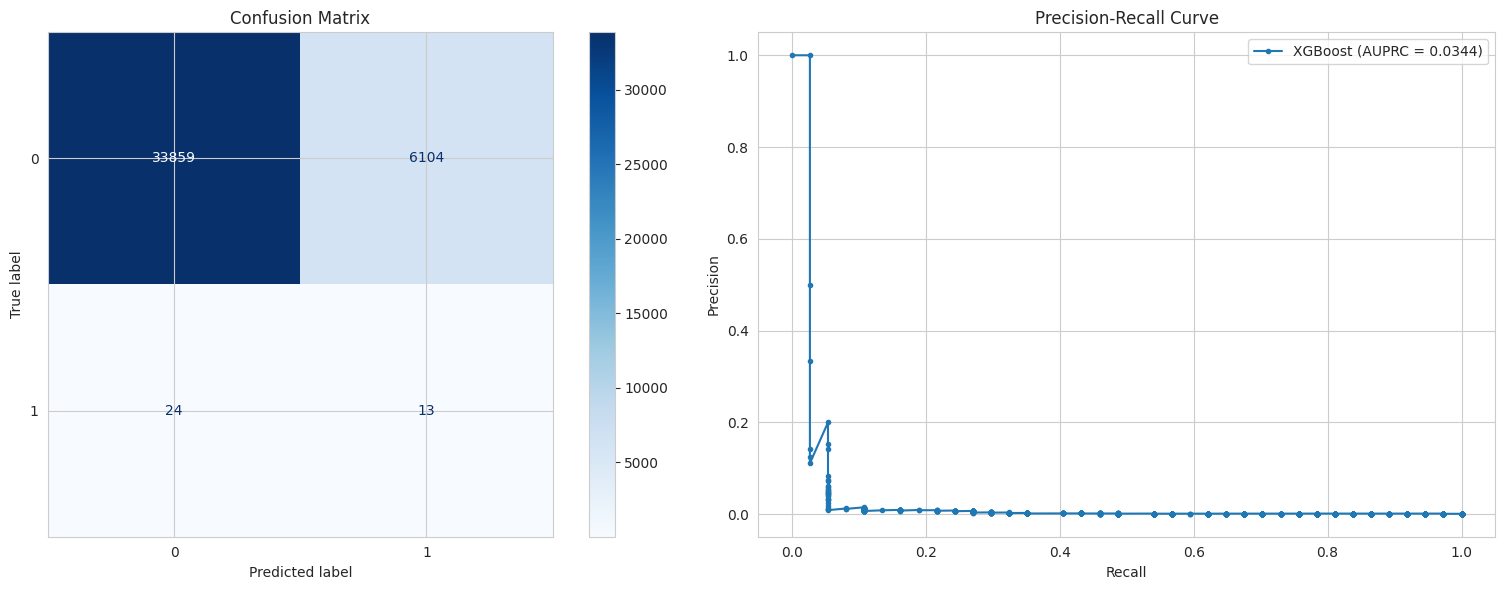

📈 Area Under Precision-Recall Curve (AUPRC): 0.0344


In [6]:
def evaluate_model(pipeline, X_test, y_test):
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # 1. Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # 2. Plot Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[0], cmap='Blues')
    axes[0].set_title("Confusion Matrix")

    # 3. Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    axes[1].plot(recall, precision, marker='.', label=f'XGBoost (AUPRC = {pr_auc:.4f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"📈 Area Under Precision-Recall Curve (AUPRC): {pr_auc:.4f}")

evaluate_model(model_pipeline, X_test, y_test)